# О программе

Данный ноутбук предназначен для моделирования процессов, происходящих в фотозеристе в ходе фотолитографии. Известным считается распределение интенсивности излучения в толще фоторезиста (скрытое изображение). Дальнейшие этапы могут быть промоделированны в данном ноутбуке. Скрытое изображение может быть вычислено в любом позволяющем это сделать САПР. В данном случае распределение интенсивности было  промоделированно в САПР Optolithium (https://github.com/xthebat/optolithium).

САПР Optolithium во многом был использован в данной работе как опорная точка, т.к. он также позволяет проводить процессное моделирование. Однако, главной его проблемой является тот факт, что в нём недоступно моделирование этапа постэкспозиционной сушки для резистов с химическим усилением, использующихся на момент написания работы повсеместно.

Таким образом, в данном ноутбуке преследовалось две цели:

1.   *Добавить способ расчёта этапа диффузии при постэкспозиционной сушке для химически усиленных резистов*, для которых этот этап имеет кардинальное отличие.
2.   *Максимально упростить запуск расчётов с помошью переноса их в один ноутбук.* Т.к. для запуска САПР Optolithium требуется виртуальная машина, установка большого кол-ва библиотек, а также в batch-режиме многократный перезапуск программы, если мы хотим подбирать параметры в цикле.

В процессе оформления кода использовался ИИ DeepSeek.

In [10]:
import numpy as np

#главный блок с симуляциями этапов
import simulation as sim
#также важный блок с визуализацией промежуточных и конечных распределений
import visualization as vis
#парсер для лога Optolithium, написан для достаточно частного случая входных данных
import parser
#блок, считающий метрики, в разработке
import metrics

# Считывание данных

In [11]:
#название файла-примера входных данных
filename = "example_input/git_example_250.txt"
#в данном случае структура одномерная, поэтому распределение двумерное
x_data, z_data, data = parser.parser_Optolithium(filename)
#parser может считывать несколько распределений интенсивности, если они в одном файле,
#но для примера ограничимся одним
I_data = data[0] 
I_data

array([[0.90787123, 0.87974881, 0.8606696 , ..., 0.97700479, 0.95326219,
        0.92636921],
       [0.90782985, 0.87970951, 0.86063147, ..., 0.97696156, 0.95322615,
        0.92633886],
       [0.90770325, 0.8795892 , 0.86051471, ..., 0.97682924, 0.95311539,
        0.92624516],
       ...,
       [0.90770325, 0.8795892 , 0.86051471, ..., 0.97682924, 0.95311539,
        0.92624516],
       [0.90782985, 0.87970951, 0.86063147, ..., 0.97696156, 0.95322615,
        0.92633886],
       [0.90787123, 0.87974881, 0.8606696 , ..., 0.97700479, 0.95326219,
        0.92636921]])

# Экспозиция

Распределение концентрации светочувствительного компонента фоторезиста (в случае ДХН резиста это PAC, в случае химически усиленных резистов это PAG) после этапа экспозиции можно вычислить по следующей формуле:

\begin{align}
    m(x, z) = exp(-C * I(x, z) * Dose)
\end{align}

где


*   $C$ - коэффициент Дилла для данного резиста
*   $I(x, z)$ - распределение интенсивности экспонирующего излучения в толще резиста (скрытое изображение)
*   $Dose$ - доза облучения фоторезиста $[\frac{мДж}{см^2}]$

In [13]:
my_exposure = sim.Exposure(dill_C=0.031)
my_m = my_exposure.simulate(intensity_in=I_data, dose=38.0)

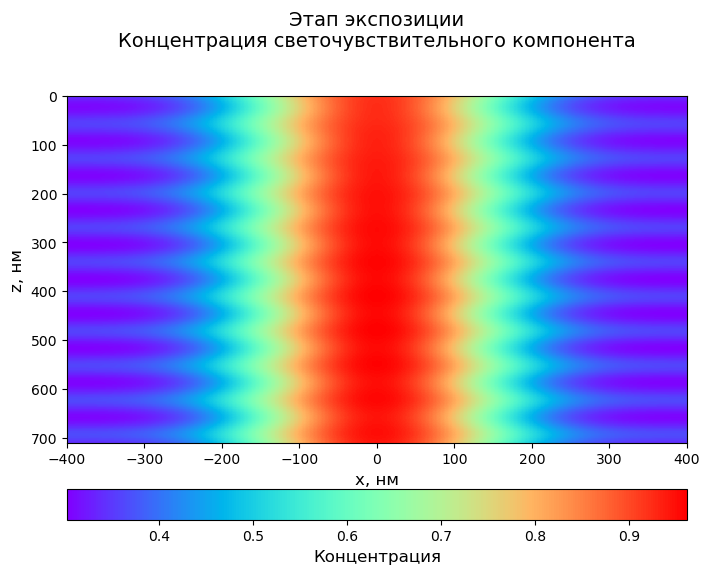

In [14]:
vis.plot_exposure(x=x_data, z=z_data, m=my_m)

# PEB

## Диффузия без химического усиления (no CAR)

Для ДХН фоторезистов этап постэкспозиционной сушки представлен диффузией его фотоактивной составляющей, которая описывается свёрткой функции распределения PAC с функцией Гаусса:


\begin{align}
    w(x, z) = m(x, z) \ast DPSF
\end{align}  


\begin{align}
    DPSF = \frac{1}{2\pi\sigma^2}exp(-\frac{x^2 + z^2}{2\sigma^2})
\end{align}

$\sigma$ выражается через постоянную диффузии как:

\begin{align}
    \sigma = \sqrt{2Dt}
\end{align}

\begin{align}
    D(T) = A_rexp(-\frac{E_a}{RT})
\end{align}

*   $A_r$ - постоянная Аррениуса для диффузии
*   $E_a$ - энергия активации реакции диффузии
*   $R$ - универсальная газовая постоянная
*   $T$ - температура

Со сравнением времени вычисления свёртки разными методами можно ознакомиться в ноутбуке PEB_сравнение_свёрток.

Нужно учитывать размер сетки, т.к. используется функция gaussian_filter, которая, в первую очередь, создана для обработки изображений, в которых нет сетки, только пиксели. Поэтому внутри функции дополнительно $\sigma$ нормируется на сетку.

In [15]:
my_PEB_noCAR = sim.PEB_noCAR(sigma=18)
my_peb = my_PEB_noCAR.simulate(step_x=5, step_z=5, m_concentration=my_m)

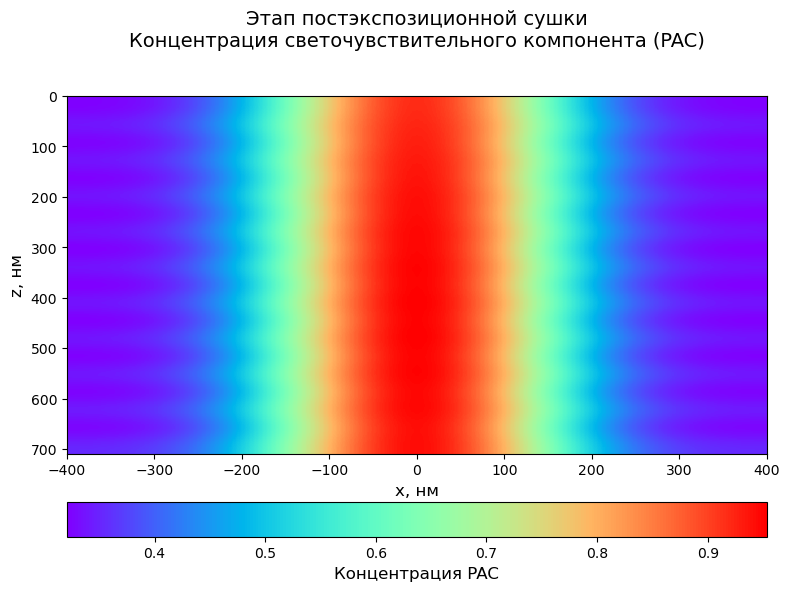

In [16]:
vis.plot_PEB_noCAR(x=x_data, z=z_data, m=my_peb)

## CAR (Диффузия для резистов с хим.усилением)

Для резиста с химическим усилением нужно решить систему дифференциальных уравнений:

\begin{align}
    \frac{\partial h}{\partial t} = \nabla (D_H \nabla h) - k_{loss}h - K_{quench}hq
\end{align}  


\begin{align}
    \frac{\partial q}{\partial t} = \nabla (D_Q \nabla q) - K_{quench}hq
\end{align}  

\begin{align}
    \frac{\partial w}{\partial t} = - K_{amp}hw
\end{align}

где:

$h$ - концентрация кислоты (начальное значение $1 - m$)

$q$ - концентрация основания (гасителя) (нужно подобрать начальное значение или найти экспериментально)

$w$ - концентрация блокированных центров полимера (начальное значение берём 1.0? или нужно подобрать)


Для решения системы ДУ с частными производными воспользуемся библиотекой **py-pde** 
(можно установить с помощью pip install, библиотека работает на Windows).

Ссылка на документацию:
https://py-pde.readthedocs.io/en/latest/index.html

Примеры из документации, которые довольно похожи на наше уравнение:

1. https://py-pde.readthedocs.io/en/latest/examples_gallery/advanced_pdes/pde_coupled.html
2. https://py-pde.readthedocs.io/en/latest/examples_gallery/advanced_pdes/pde_sir.html

Все коэффициенты внутри будут нормироваться на сетку.

In [17]:
my_PEB_CAR = sim.PEB_CAR(D_h=0.1, D_q=0.1, K_a=0.1, K_q=0.1, step_x=5, step_z=5)
res = my_PEB_CAR.simulate(q0=0.1, w0=1.0, t=90, x=x_data, z=z_data, m_concentration=my_m)

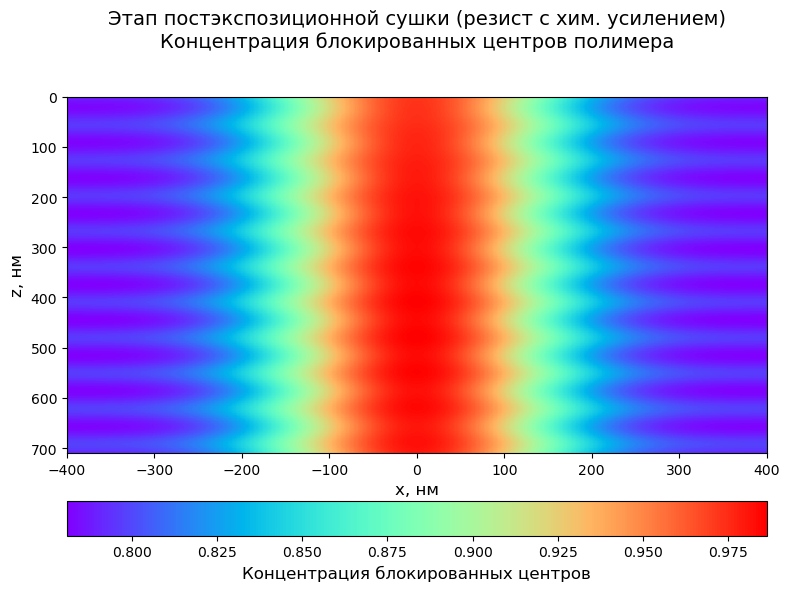

In [18]:
vis.plot_PEB_CAR(x=x_data, z=z_data, m=res)

# Проявление (скорости)

**Mack model**

**1 - Модель Мака (Mack model)**

\begin{align}
    R(m) = R_{max}\frac{(a + 1)(1 - m)^n}{a + (1 - m)^n} + R_{min}
\end{align}

параметр $a$ может быть выражен через величину $m_{th}$ - характерную точку перегиба графика как:

\begin{align}
    a = \frac{(n + 1)}{(n - 1)}(1 - m_{th})^n
\end{align}

In [19]:
my_dev = sim.DevelopmentMack(rmin=0.1, rmax=120, n=14, mth=0.2)
my_rates1 = my_dev.simulate(my_peb)

**Enhanced model**

**2 - Улучшенная модель Мака (Enhanced model)**

\begin{align}
    R(m) = R_{resin}\frac{1 + k_{enh}(1 - m)^n}{1 + k_{inh}(m)^l}
\end{align}

параметры $k_{enh}$ и $k_{inh}$ можно выразить через $R_{min}$ и $R_{max}$ как:

\begin{align}
    R_{min} = \frac{R_{resin}}{1 + k_{inh}}
\end{align}

\begin{align}
    R_{max} = R_{resin}(1 + k_{enh})
\end{align}

In [20]:
my_dev = sim.DevelopmentEnhanced(rmin=0.1, rmax=120, rresin=13, n=14, l=14)
my_rates = my_dev.simulate(m_in=my_peb)

**Notch model**

**3 - Модель с выемкой (Notch model)**

\begin{align}
    R(m) = R_{max}(1 - m)^n \left[ \frac{(a + 1)(1 - m)^{n_{notch}}}{a + (1 - m)^{n_{notch}}} \right] + R_{min}
\end{align}

параметр $a$ можно выразить через $n_{notch}$ и $m_{th}$ как:

\begin{align}
    a = \frac{(n_{notch} + 1)}{(n_{notch} - 1)}{(1 - m_{th})}^{n_{notch}}
\end{align}

In [21]:
my_dev = sim.DevelopmentNotch(rmin=0.1, rmax=120, n=13, mth=0.3, nnotch=14)
my_rates1 = my_dev.simulate(my_peb)

**Enhanced Notch model**

**4 - Улучшенная модель с выемкой (Enhanced notch model)**

\begin{align}
    R(m) = R_{max}(1 - m)^n \left[ \frac{(a + 1)(1 - m)^{n_{notch}}}{a + (1 - m)^{n_{notch}}} \right] + R_{min}\left[\frac{S}{S^m}\right]\left[1 - \frac{(a + 1)(1 - m)^n_{notch}}{a + (1 - m)^n_{notch}}\right]^2
\end{align}

параметр $a$ можно выразить через $n_{notch}$ и $m_{th}$ как:

\begin{align}
    a = \frac{(n_{notch} + 1)}{(n_{notch} - 1)}(1 - m_{th})^n_{notch}
\end{align}

In [22]:
my_dev = sim.DevelopmentNotchEnhanced(rmin=0.1, rmax=120, n=13, mth=0.3, nnotch=14, s=5.0)
my_rates1 = my_dev.simulate(my_peb)

**Notch model + deep dependance**

**5 - Модель с выемкой с учётом поверхностного ингибитирования**

\begin{align}
    R(m, z) = \left(R_{max}(1 - m)^n \left[ \frac{(a + 1)(1 - m)^{n_{notch}}}{a + (1 - m)^{n_{notch}}} \right] + R_{min}\right) exp(-\frac{z}{\delta})
\end{align}

параметр $a$ можно выразить через $n_{notch}$ и $m_{th}$ как:

\begin{align}
    a = \frac{(n_{notch} + 1)}{(n_{notch} - 1)}(1 - m_{th})^n_{notch}
\end{align}

In [23]:
my_dev = sim.DevelopmentNotchInhibition(rmin=0.1, rmax=120, n=13, mth=0.3, nnotch=14, delta=50)
my_rates1 = my_dev.simulate(my_peb, z_data)

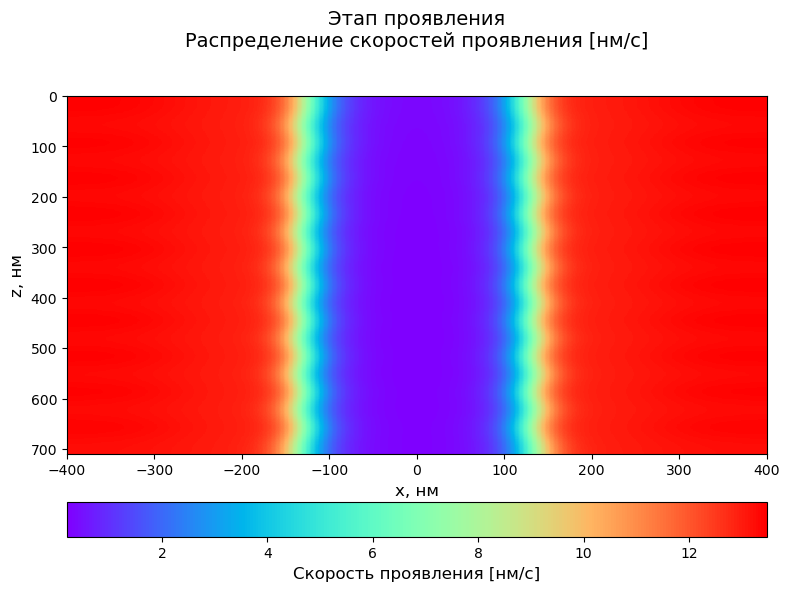

In [24]:
vis.plot_development(x=x_data, z=z_data, r=my_rates)

# Проявление (контуры)

Обозначим путь проявления за $s$.

\begin{align}
    r = \frac{ds}{dr}
\end{align}

Интегрируя, получаем интеграл по пути:

\begin{align}
    t_{dev} = ∮_{path}\frac{ds}{r(x, y, z)}
\end{align}

Параметризуем путь (на примере 2D):

\begin{align}
    \Delta s = \sqrt{\Delta x^2 + \Delta z^2} = \Delta x \sqrt{1 + \left(\frac{\Delta z}{\Delta x}\right)^2}
\end{align}

\begin{align}
    ds = dx\sqrt{1 + z'^2}
\end{align}

Тогда интеграл становится равным:

\begin{align}
    t_{dev} = \int_{path}\frac{dx\sqrt{1 + z'^2}}{r(x, z)}
\end{align}

Далее нужно воспользоваться принципом наименьшего действия. То есть путь должен быть таким, чтобы минимизировать интеграл в уравнении выше. Из теории вариационного исчисления следует, что $\int{f(x, z, z')dx}$ достигнет минимума там, где удовлетворяется уравнение Эйлера-Лагранжа. Или можно пойти по другому пути (что в литографии и делается) и определить поверхность постоянного времени проявления через уравнение Гамильтона-Якоби:

\begin{align}
    \left(\frac{\partial t}{\partial x}\right)^2 + \left(\frac{\partial t}{\partial z}\right)^2 = \frac{1}{r^2}
\end{align}

*Прочитать о том, каким образом из задачи поиска минимума нашего интеграла получается уравнение выше, можно в лекции (конкретно этот случай разобран в разделе "Пример 1: функционал Ферма"):*

https://mph.phys.spbu.ru/wp-content/uploads/2020/03/lect_22_04.pdf

Получившееся уравнение является аналогом уравнения Эйконала из геометрической оптики.

Подсчёт контуров проявления производится через численное решение уравнения типа уравнения эйконала с помощью **библиотеки pykonal**.

Гитхаб с библиотекой и ссылки от разработчиков:
https://github.com/malcolmw/pykonal

Тут документация:
https://malcolmw.github.io/pykonal-docs/

А вот тут статья на русском, где "на пальцах" объясняется, как работает FMM (Fast Marching Method):

https://habr.com/ru/articles/785990/

**Внимание!** Эта библиотека ломается на винде.

В колабе всё ОК, проблемы появляются, если попробовать запустить код на компьютере с ОС Windows, например, в Jupyter Notebook.

Проблема и её решение описаны здесь здесь:

https://github.com/malcolmw/pykonal/pull/46

Но нельзя просто поменять строчку кода в уже установленном пакете pykonal, Jupyter эти изменения не увидит. 

Поэтому **решение** следующее:

1.  На гитхабе библиотеки смотрим на способ установки из исходников и скачиваем оттуда зазипованный latest release https://github.com/malcolmw/pykonal/tree/master?tab=readme-ov-file#from-source-code

2. Распаковываем архив.

3. В файле heapq.pyx дописываем в 36-ую строчку нужные слова, как написано в https://github.com/malcolmw/pykonal/pull/46


self.cy_heap_index = np.full(values.shape, fill_value=-1**, dtype=np.intp**)

4. В терминале виртуальной среды переходим в наш распакованных архив с пофикшенной строкой и устанавливаем пакет с помощью pip install .

In [25]:
my_timecont = sim.TimeContours()
my_cont = my_timecont.simulate(x_in=x_data, z_in=z_data, rates=my_rates)

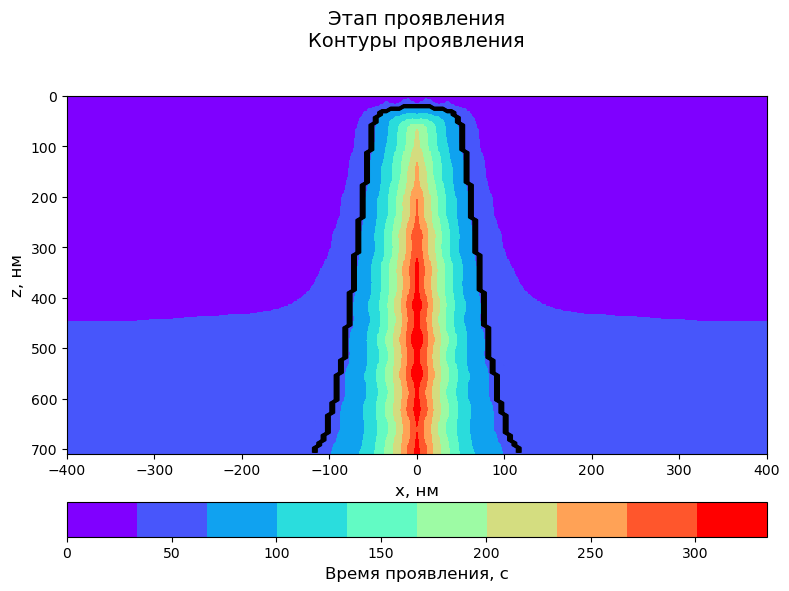

In [26]:
my_cmap = vis.discrete_cmap(N=10, base_cmap='rainbow')
c = vis.plot_contour(x=x_data, z=z_data, c=my_cont, t=60, my_cmap=my_cmap)

# Метрики

Модуль с метриками предназначен в основном для решения конкретной задачи (данные здесь не указаны), поэтому может работать криво с некоторыми данными. Тем не менее, для наглядности был также выложен.

107.0248393815619


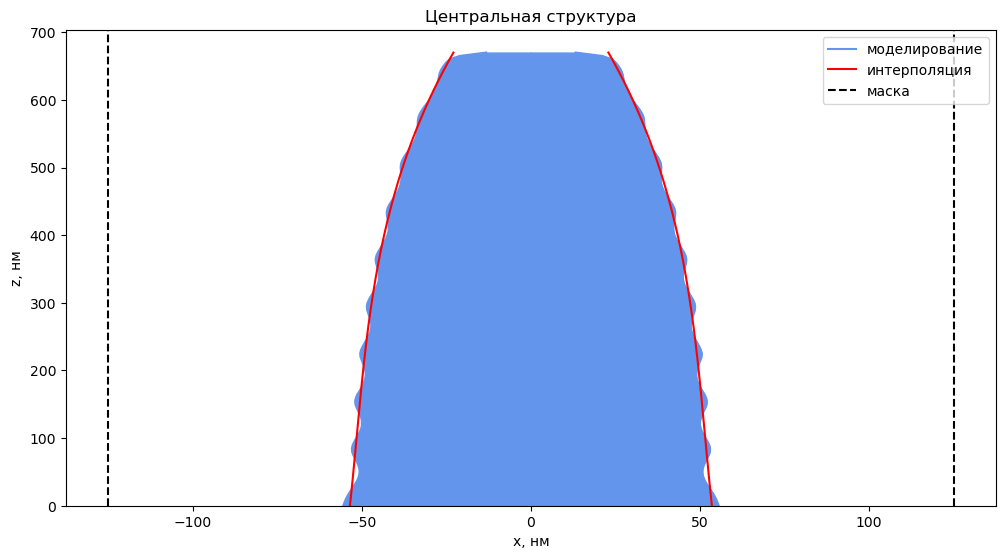

In [28]:
my_metrics = metrics.Metrics(up_level=0.95, down_level=0.0, mode='poly3')
left, right = my_metrics.find_contour(conts=my_cont, x_in=x_data, z_in=z_data, 
                                      x_stop_l=-300, x_stop_r=280, t=120)
CD, rms_l, rms_l = my_metrics.find_metrics(left_points=left, right_points=right,
                                           z_data=z_data, CD_x=(-125, 125), plot=True)

print(CD)